<a href="https://colab.research.google.com/github/nthanhkhang/vietnamese-pos-tagging/blob/main/Finnal_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Detection
    
    The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

    Acknowledgements

    The original dataset can be found in https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection. The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.






In [249]:
!wget https://raw.githubusercontent.com/nthanhkhang/Natural-Language-Processing/main/Data/sms_spam.csv

--2021-04-01 14:20:52--  https://raw.githubusercontent.com/nthanhkhang/Natural-Language-Processing/main/Data/sms_spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘sms_spam.csv.31’

sms_spam.csv.31     100%[===================>] 491.86K  --.-KB/s    in 0.01s   

2021-04-01 14:20:52 (45.3 MB/s) - ‘sms_spam.csv.31’ saved [503663/503663]



### 1. Import Packages

In [250]:
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from numpy import sqrt
from numpy import mean
from numpy import absolute

from sklearn import tree
from sklearn.model_selection import KFold
from sklearn import metrics
import time

import string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn import svm
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. Dataset Loading and Data Preprocessing

#### 2.1. Read dataset using pandas

In [251]:
sms = pd.read_csv("sms_spam.csv", encoding='latin-1') 
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### 2.2. Remove redundant attributes

In [252]:
sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1, inplace = True)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 2.3. Rename columns
Requires: v1 -> label, v2 -> message

In [253]:
sms.columns = ["label", "message"]
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 2.4. Modify columns
Requires: change ham to 0, and spam to 1 in Label Attribute.

In [254]:
sms['label_num']=sms['label'].apply(len)
sms.head()
for i in sms.index:
  if sms['label'][i]=='ham':
    sms['label_num'][i]=0
  else:
    sms['label_num'][i]=1
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### 2.5. Add new column
Requires: Add message_len Attribute that is the length of the message.

In [255]:
sms['length']=sms['message'].apply(len)
sms.head()

,label,message,label_num,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


#### 2.6. Histogram graph

Text(0.5, 0, 'Message Length')

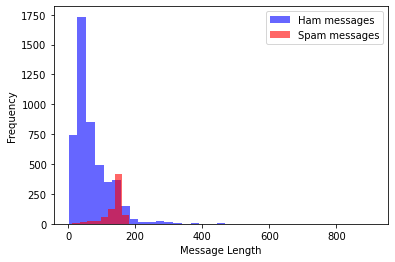

In [256]:
plt.figure(figsize=(6, 4))

sms[sms.label_num==0].length.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label_num==1].length.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

#### 2.7. Preprocessing text 
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text

In [257]:
def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [258]:
# Apply the above function to preprocess the text.
sms['clean_messages'] = sms.message.apply(text_process)
sms.head()

,label,message,label_num,length,clean_messages
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [259]:
# Draw Histogram graph again with clean messages.
sms['clean_length']=sms['clean_messages'].apply(len)
sms.head()

,label,message,label_num,length,clean_messages,clean_length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...,82
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni,21
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...,133
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though,38


Text(0.5, 0, 'Message Length')

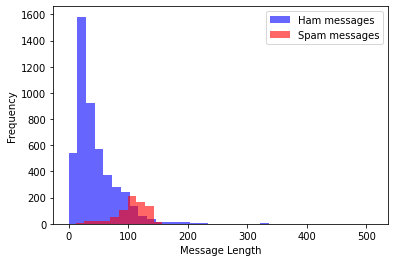

In [260]:
plt.figure(figsize=(6, 4))

sms[sms.label_num==0].clean_length.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label_num==1].clean_length.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [261]:
# split X and y into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(sms['clean_messages'], sms['label_num'], random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


#### 2.8. Feature extraction using TfidfVectorizer

In [262]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_TfidfVectorizer = vectorizer.transform(X_train)
X_train_TfidfVectorizer = vectorizer.fit_transform(X_train)
X_test_TfidfVectorizer = vectorizer.transform(X_test)

#### 2.9. Feature extraction using HashingVectorizer

In [263]:
vectorizer = HashingVectorizer()
vectorizer.fit(X_train)
X_train_HashingVectorizer = vectorizer.transform(X_train)
X_train_HashingVectorizer = vectorizer.fit_transform(X_train)
X_test_HashingVectorizer = vectorizer.transform(X_test)

#### 2.10. Feature extraction using CountVectorizer

In [264]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_CountVectorizer = vectorizer.transform(X_train)
X_train_CountVectorizer = vectorizer.fit_transform(X_train)
X_test_CountVectorizer = vectorizer.transform(X_test)

#### 2.11. Your contributions

    Create clean_msg_2 with your text_process function. 
    Then, apply feature extraction using TfidfVectorizer, HashingVectorizer and CountVectorizer
    Compare the result with the default text_process function. 

In [265]:
# remove English stop words
vect = CountVectorizer(stop_words='english')
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

In [266]:
from sklearn.feature_extraction.text import CountVectorizer
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)
# learn training data vocabulary, then use it to create a document-term matrix
X_train_CountVectorizer = vect.transform(X_train)
# equivalently: combine fit and transform into a single step
X_train_CountVectorizer = vect.fit_transform(X_train)
# examine the document-term matrix
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_CountVectorizer = vect.transform(X_test)

In [267]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_test_CountVectorizer)
tfidf_transformer.transform(X_test_CountVectorizer)

<1393x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 9971 stored elements in Compressed Sparse Row format>

In [268]:
# Apply the above function to preprocess the text.
sms['clean_msg_2'] = sms.message.apply(text_process)
sms.head()

,label,message,label_num,length,clean_messages,clean_length,clean_msg_2
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...,82,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni,21,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...,133,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say,31,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though,38,Nah think goes usf lives around though


In [269]:
# split X and y into training and testing sets 
X_train_clean_msg_2, X_test_clean_msg_2, y_train_clean_msg_2, y_test_clean_msg_2 = train_test_split(sms['clean_msg_2'], sms['label_num'], random_state=1)

In [270]:
model = tree.DecisionTreeClassifier()
%time model.fit(X_train_CountVectorizer, y_train_clean_msg_2)
# make class predictions for X_test_dtm
y_pred_class = model.predict(X_test_CountVectorizer)

CPU times: user 132 ms, sys: 2.97 ms, total: 135 ms
Wall time: 140 ms


In [271]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9612347451543432

# 3. Spam detection




In [272]:
y = sms.label

# only using the decision tree classifier with default setting for training and predicting. 
# In other words, make no changes to this section.

model = tree.DecisionTreeClassifier()

#### 3.1. Using TF-IDF Vectorizer

    Requirements:
    1. Using 5-fold for spliting the dataset 
    2. Add accuracy of each fold to acc_tv
    3. Caculate and print the proccessing time
    4. Print mean of accuracy

In [273]:
acc_tv=[]
cv = KFold(n_splits=5, random_state=1, shuffle=True)
%time acc_tv = cross_val_score(model, X_train_TfidfVectorizer, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("Accurancy",sqrt(mean(absolute(acc_tv))))

CPU times: user 29.5 ms, sys: 8.87 ms, total: 38.3 ms
Wall time: 739 ms
Accurancy 0.9806704165035426


#### 3.2. Using Hashing Vectorizer
    Requirements:
    1. Using 5-fold for spliting the dataset 
    2. Add accuracy of each fold to acc_hv
    3. Caculate and print the proccessing time
    4. Print mean of accuracy

In [274]:
acc_hv = []
cv = KFold(n_splits=5, random_state=1, shuffle=True)
%time acc_hv = cross_val_score(model, X_train_HashingVectorizer, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("Accurancy",sqrt(mean(absolute(acc_hv))))

CPU times: user 108 ms, sys: 5.6 ms, total: 113 ms
Wall time: 15.8 s
Accurancy 0.9774940698642497


#### 3.3. Using Count Vectorizer

    Requirements:
    1. Using 5-fold for spliting the dataset 
    2. Add accuracy of each fold to acc_cv
    3. Caculate and print the proccessing time
    4. Print mean of accuracy

In [275]:
acc_cv=[]
cv = KFold(n_splits=5, random_state=1, shuffle=True)
%time acc_cv = cross_val_score(model, X_train_CountVectorizer, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("Accurancy",sqrt(mean(absolute(acc_cv))))

CPU times: user 32.5 ms, sys: 1.13 ms, total: 33.6 ms
Wall time: 540 ms
Accurancy 0.9809150662755509


#### 3.4. Ploting Accuracies in 5-Folds

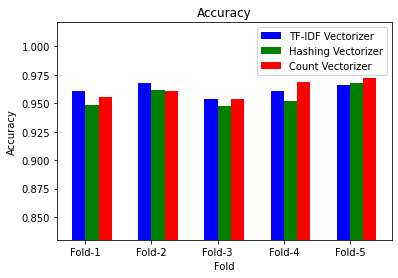

In [276]:
plt.figure(figsize=(6, 4))

index=np.arange(5)

width=0.20
D=['Fold-1','Fold-2','Fold-3','Fold-4','Fold-5']

plt.bar(index,acc_tv,width,color='blue',label='TF-IDF Vectorizer')
plt.bar(index+width,acc_hv,width,color='green',label='Hashing Vectorizer')
plt.bar(index+2*width,acc_cv,width,color='red',label='Count Vectorizer')

plt.title("Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

plt.xticks(index+width/2,D)

plt.ylim(0.83)

plt.legend(loc='best')
plt.show()


# 4.Predict whether a sentence is spam or ham





## 4.1 Stopwords

In [277]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

##4.2 Converting messages to lowercase

In [278]:
def review_messages(msg):
    msg = msg.lower()
    return msg

## 4.3 Preprocessing text

In [279]:
def alternative_review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()

    # uses a lemmatizer (wnpos is the parts of speech tag)
    # unfortunately wordnet and nltk uses a different set of terminology for pos tags
    # first, we must translate the nltk pos to wordnet
    nltk_pos = [tag[1] for tag in pos_tag(word_tokenize(msg))]
    msg = [tag[0] for tag in pos_tag(word_tokenize(msg))]
    wnpos = ['a' if tag[0] == 'J' else tag[0].lower() if tag[0] in ['N', 'R', 'V'] else 'n' for tag in nltk_pos]
    msg = " ".join([lemmatizer.lemmatize(word, wnpos[i]) for i, word in enumerate(msg)])

    # removing stopwords 
    msg = [word for word in msg.split() if word not in stopwords]

    return msg

In [280]:
# Processing text messages
sms['clean_messages'] = sms['clean_messages'].apply(review_messages)

# train test split 
X_train, X_test, y_train, y_test = train_test_split(sms['clean_messages'], sms['label'], test_size = 0.1, random_state = 1)

In [281]:
# training vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [282]:
# training the classifier 
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [283]:
# testing against testing set 
X_test = vectorizer.transform(X_test)
y_pred = svm.predict(X_test) 
#print(confusion_matrix(y_test, y_pred))

[[490   0]
 [  6  62]]


In [284]:
# test against new messages 
def pred(msg):
    msg = vectorizer.transform([msg])
    prediction = svm.predict(msg)
    return prediction[0]

pred("Go jurong point crazy Available bugis n great ...")

'ham'